In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects


file_path = r"E:\Projects\Gamezone Orders Data\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_name_cleaned  8 non-null      object 
 1   total_revenue         8 non-null      float64
 2   total_orders          8 non-null      int64  
 3   avg_price             8 non-null      float64
 4   total_customers       8 non-null      int64  
 5   repeat_buyers         8 non-null      float64
 6   rpr_%                 8 non-null      float64
 7   revenue_%_of_total    8 non-null      float64
 8   cumulative_revenue_%  8 non-null      float64
 9   revenue_per_order     8 non-null      float64
 10  abc_class             8 non-null      object 
dtypes: float64(7), int64(2), object(2)
memory usage: 836.0+ bytes


In [2]:
df['product_name_cleaned'].value_counts()

product_name_cleaned
nintendo switch                   10386
27in 4k gaming monitor             4723
jbl quantum 100 gaming headset     4296
sony playstation 5 bundle           977
dell gaming mouse                   719
lenovo ideapad gaming 3             669
acer nitro v gaming laptop           87
razer pro gaming headset              7
Name: count, dtype: int64

In [3]:
# --- 💰 PRODUCT PERFORMANCE PIVOT TABLE ---
# ✅ 1️⃣ Aggregate revenue, orders, and average price by product
product_performance = (
    df.groupby(['product_name_cleaned'])
    .agg(
        total_revenue=('revenue', 'sum'),
        total_orders=('order_id', 'count'),
        avg_price=('revenue', 'mean')
    )
    .reset_index()
)

# ✅ 2️⃣ Sort by revenue descending
product_performance = product_performance.sort_values(by='total_revenue', ascending=False)

# ✅ 3️⃣ Add "% of Total Revenue"
total_revenue_sum = product_performance['total_revenue'].sum()
product_performance['revenue_%_of_total'] = (
    product_performance['total_revenue'] / total_revenue_sum * 100
).round(2)

# ✅ 4️⃣ Add Running Total (Cumulative % of Total Revenue)
product_performance['cumulative_revenue_%'] = (
    product_performance['revenue_%_of_total'].cumsum()
).round(2)

# ✅ 9️⃣ Add Revenue per Order (efficiency metric)
product_performance['revenue_per_order'] = (
    product_performance['total_revenue'] / product_performance['total_orders']
).round(2)

# ✅ 1️⃣1️⃣ Add ABC Classification (Pareto Analysis)
def classify_abc(cumulative_pct):
    if cumulative_pct <= 80:
        return 'A'
    elif cumulative_pct <= 95:
        return 'B'
    else:
        return 'C'

product_performance['abc_class'] = product_performance['cumulative_revenue_%'].apply(classify_abc)

# ✅ 5️⃣ Identify Top 3 Products
top3 = product_performance.head(3)
top3_products = top3['product_name_cleaned'].tolist()
top3_revenue_share = round(top3['revenue_%_of_total'].sum(), 2)

# ✅ 6️⃣ Identify Bottom Performers (low revenue products)
bottom_products = product_performance.tail(3)

# ✅ 🔟 Identify "Hidden Gems" - high avg price but low total revenue
# (might benefit from marketing push)
high_value_low_volume = product_performance[
    (product_performance['avg_price'] > product_performance['avg_price'].median()) &
    (product_performance['total_revenue'] < product_performance['total_revenue'].median())
]

# ✅ 7️⃣ Print Key Insights
print("🔝 Top 3 Products by Revenue:")
for i, row in top3.iterrows():
    print(f"  • {row['product_name_cleaned']}: ${row['total_revenue']:,.2f}")

print(f"\n💰 Top 3 products contribute {top3_revenue_share}% of total revenue.")

print("\n⬇️ Bottom Performers:")
for i, row in bottom_products.iterrows():
    print(f"  • {row['product_name_cleaned']}: ${row['total_revenue']:,.2f}")

# ✅ 1️⃣2️⃣ Print additional insights
print("\n💎 Hidden Gems (High Value, Low Volume):")
if len(high_value_low_volume) > 0:
    for i, row in high_value_low_volume.head(3).iterrows():
        print(f"  • {row['product_name_cleaned']}: ${row['avg_price']:,.2f} avg price, only {row['total_orders']} orders")
else:
    print("  No hidden gems identified.")

print("\n📦 ABC Classification:")
print(f"  Class A (80% revenue): {len(product_performance[product_performance['abc_class']=='A'])} products")
print(f"  Class B (80-95% revenue): {len(product_performance[product_performance['abc_class']=='B'])} products")
print(f"  Class C (95-100% revenue): {len(product_performance[product_performance['abc_class']=='C'])} products")



# --- 🧠 LOG INSIGHT #1 ---
print("\n📊 LOG INSIGHT #1")
print(f"Metric: Revenue concentration")
print(f"Dimension: Product")
print(f"Observation: Top 3 products ({', '.join(top3_products)}) = {top3_revenue_share}% of total revenue")
print(f"Stakeholder: CEO, Product Manager")
print(f"Priority: HIGH")
print(f"Action: Focus inventory and marketing efforts on top performers.")

# --- 🧠 LOG INSIGHT #2 ---
print("\n📊 LOG INSIGHT #2")
print(f"Metric: ABC Classification")
print(f"Dimension: Product Portfolio")
print(f"Observation: {len(product_performance[product_performance['abc_class']=='A'])} products drive 80% of revenue")
print(f"Stakeholder: Operations, Inventory Manager")
print(f"Priority: MEDIUM")
print(f"Action: Prioritize Class A inventory management and customer service.")

product_performance

🔝 Top 3 Products by Revenue:
  • 27in 4k gaming monitor: $1,968,565.34
  • nintendo switch: $1,658,717.65
  • sony playstation 5 bundle: $1,589,243.85

💰 Top 3 products contribute 84.81% of total revenue.

⬇️ Bottom Performers:
  • acer nitro v gaming laptop: $65,661.18
  • dell gaming mouse: $36,490.01
  • razer pro gaming headset: $884.23

💎 Hidden Gems (High Value, Low Volume):
  • acer nitro v gaming laptop: $754.73 avg price, only 87 orders

📦 ABC Classification:
  Class A (80% revenue): 2 products
  Class B (80-95% revenue): 1 products
  Class C (95-100% revenue): 5 products

📊 LOG INSIGHT #1
Metric: Revenue concentration
Dimension: Product
Observation: Top 3 products (27in 4k gaming monitor, nintendo switch, sony playstation 5 bundle) = 84.81% of total revenue
Stakeholder: CEO, Product Manager
Priority: HIGH
Action: Focus inventory and marketing efforts on top performers.

📊 LOG INSIGHT #2
Metric: ABC Classification
Dimension: Product Portfolio
Observation: 2 products drive 80% 

,product_name_cleaned,total_revenue,total_orders,avg_price,revenue_%_of_total,cumulative_revenue_%,revenue_per_order,abc_class
0,27in 4k gaming monitor,1968565.34,4723,417.511207,32.00,32.00,416.80,A
5,nintendo switch,1658717.65,10386,159.707072,26.97,58.97,159.71,A
7,sony playstation 5 bundle,1589243.85,977,1626.656960,25.84,84.81,1626.66,B
4,lenovo ideapad gaming 3,735506.56,669,1099.411898,11.96,96.77,1099.41,C
3,jbl quantum 100 gaming headset,96197.67,4296,22.502379,1.56,98.33,22.39,C
1,acer nitro v gaming laptop,65661.18,87,754.726207,1.07,99.40,754.73,C
2,dell gaming mouse,36490.01,719,51.106457,0.59,99.99,50.75,C
6,razer pro gaming headset,884.23,7,126.318571,0.01,100.00,126.32,C


In [4]:
# --- 💰 PRODUCT PERFORMANCE PIVOT TABLE ---
# ✅ 1️⃣ Aggregate revenue, orders, and average price by product
product_performance = (
    df.groupby(['product_name_cleaned'])
    .agg(
        total_revenue=('revenue', 'sum'),
        total_orders=('order_id', 'count'),
        avg_price=('revenue', 'mean'),
        total_customers=('user_id', 'nunique')  # total unique customers per product
    )
    .reset_index()
)

# ✅ 1️⃣a Add Repeat Purchase Rate (RPR)
# Step 1: Count repeat buyers per product
repeat_buyers = (
    df.groupby(['product_name_cleaned', 'user_id'])
    .size()
    .reset_index(name='purchase_count')
)

repeat_buyers = repeat_buyers[repeat_buyers['purchase_count'] > 1]

# Step 2: Count unique repeat buyers per product
repeat_buyers_count = repeat_buyers.groupby('product_name_cleaned')['user_id'].nunique().reset_index()
repeat_buyers_count.rename(columns={'user_id': 'repeat_buyers'}, inplace=True)

# Step 3: Merge with product_performance
product_performance = product_performance.merge(repeat_buyers_count, on='product_name_cleaned', how='left')
product_performance['repeat_buyers'] = product_performance['repeat_buyers'].fillna(0)

# Step 4: Calculate RPR %
product_performance['rpr_%'] = (
    product_performance['repeat_buyers'] / product_performance['total_customers'] * 100
).round(2)

# ✅ 2️⃣ Sort by revenue descending
product_performance = product_performance.sort_values(by='total_revenue', ascending=False)

# ✅ 3️⃣ Add "% of Total Revenue"
total_revenue_sum = product_performance['total_revenue'].sum()
product_performance['revenue_%_of_total'] = (
    product_performance['total_revenue'] / total_revenue_sum * 100
).round(2)

# ✅ 4️⃣ Add Running Total (Cumulative % of Total Revenue)
product_performance['cumulative_revenue_%'] = (
    product_performance['revenue_%_of_total'].cumsum()
).round(2)

# ✅ 9️⃣ Add Revenue per Order (efficiency metric)
product_performance['revenue_per_order'] = (
    product_performance['total_revenue'] / product_performance['total_orders']
).round(2)

# ✅ 1️⃣1️⃣ Add ABC Classification (Pareto Analysis)
def classify_abc(cumulative_pct):
    if cumulative_pct <= 80:
        return 'A'
    elif cumulative_pct <= 95:
        return 'B'
    else:
        return 'C'

product_performance['abc_class'] = product_performance['cumulative_revenue_%'].apply(classify_abc)

# ✅ 1️⃣2️⃣ Print additional insights
print("\n💎 Hidden Gems (High Value, Low Volume):")
if len(high_value_low_volume) > 0:
    for i, row in high_value_low_volume.head(3).iterrows():
        print(f"  • {row['product_name_cleaned']}: ${row['avg_price']:,.2f} avg price, only {row['total_orders']} orders")
else:
    print("  No hidden gems identified.")

print("\n📦 ABC Classification:")
print(f"  Class A (80% revenue): {len(product_performance[product_performance['abc_class']=='A'])} products")
print(f"  Class B (80-95% revenue): {len(product_performance[product_performance['abc_class']=='B'])} products")
print(f"  Class C (95-100% revenue): {len(product_performance[product_performance['abc_class']=='C'])} products")

# Add these BEFORE the print statements:

# For Hidden Gems
high_value_low_volume = product_performance[
    (product_performance['avg_price'] > product_performance['avg_price'].quantile(0.75)) &
    (product_performance['total_orders'] < product_performance['total_orders'].quantile(0.25))
]

# For Top 3 Products
top3_products = product_performance.head(3)['product_name_cleaned'].tolist()
top3_revenue_share = product_performance.head(3)['revenue_%_of_total'].sum().round(2)



# --- 🧠 LOG INSIGHT #1 ---
print("\n📊 LOG INSIGHT #1")
print(f"Metric: Revenue concentration")
print(f"Dimension: Product")
print(f"Observation: Top 3 products ({', '.join(top3_products)}) = {top3_revenue_share}% of total revenue")
print(f"Stakeholder: CEO, Product Manager")
print(f"Priority: HIGH")
print(f"Action: Focus inventory and marketing efforts on top performers.")

# --- 🧠 LOG INSIGHT #2 ---
print("\n📊 LOG INSIGHT #2")
print(f"Metric: ABC Classification")
print(f"Dimension: Product Portfolio")
print(f"Observation: {len(product_performance[product_performance['abc_class']=='A'])} products drive 80% of revenue")
print(f"Stakeholder: Operations, Inventory Manager")
print(f"Priority: MEDIUM")
print(f"Action: Prioritize Class A inventory management and customer service.")

product_performance



💎 Hidden Gems (High Value, Low Volume):
  • acer nitro v gaming laptop: $754.73 avg price, only 87 orders

📦 ABC Classification:
  Class A (80% revenue): 2 products
  Class B (80-95% revenue): 1 products
  Class C (95-100% revenue): 5 products

📊 LOG INSIGHT #1
Metric: Revenue concentration
Dimension: Product
Observation: Top 3 products (27in 4k gaming monitor, nintendo switch, sony playstation 5 bundle) = 84.81% of total revenue
Stakeholder: CEO, Product Manager
Priority: HIGH
Action: Focus inventory and marketing efforts on top performers.

📊 LOG INSIGHT #2
Metric: ABC Classification
Dimension: Product Portfolio
Observation: 2 products drive 80% of revenue
Stakeholder: Operations, Inventory Manager
Priority: MEDIUM
Action: Prioritize Class A inventory management and customer service.


,product_name_cleaned,total_revenue,total_orders,avg_price,total_customers,repeat_buyers,rpr_%,revenue_%_of_total,cumulative_revenue_%,revenue_per_order,abc_class
0,27in 4k gaming monitor,1968565.34,4723,417.511207,4358,354.0,8.12,32.00,32.00,416.80,A
5,nintendo switch,1658717.65,10386,159.707072,9686,677.0,6.99,26.97,58.97,159.71,A
7,sony playstation 5 bundle,1589243.85,977,1626.656960,900,76.0,8.44,25.84,84.81,1626.66,B
4,lenovo ideapad gaming 3,735506.56,669,1099.411898,617,51.0,8.27,11.96,96.77,1099.41,C
3,jbl quantum 100 gaming headset,96197.67,4296,22.502379,4025,262.0,6.51,1.56,98.33,22.39,C
1,acer nitro v gaming laptop,65661.18,87,754.726207,78,9.0,11.54,1.07,99.40,754.73,C
2,dell gaming mouse,36490.01,719,51.106457,647,71.0,10.97,0.59,99.99,50.75,C
6,razer pro gaming headset,884.23,7,126.318571,7,0.0,0.00,0.01,100.00,126.32,C


In [5]:
# ✅ 8️⃣ Save to CSV
product_performance.to_csv("product_performance.csv", index=False)

C:\Users\shaif\AppData\Local\Temp\ipykernel_17152\3850991685.py:41: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.tight_layout()
c:\Users\shaif\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


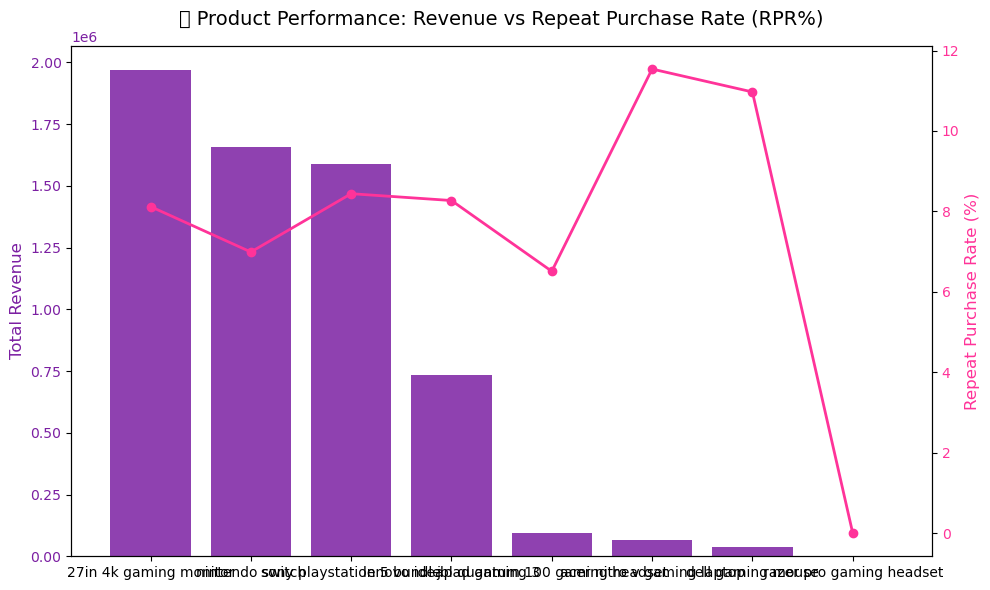

C:\Users\shaif\AppData\Local\Temp\ipykernel_17152\3850991685.py:64: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\shaif\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


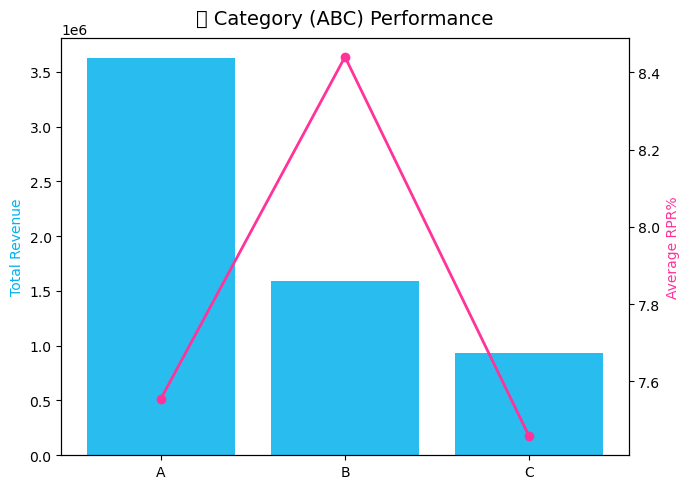

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 💾 Load Data ---
data = {
    'product_name_cleaned': [
        '27in 4k gaming monitor', 'nintendo switch', 'sony playstation 5 bundle',
        'lenovo ideapad gaming 3', 'jbl quantum 100 gaming headset',
        'acer nitro v gaming laptop', 'dell gaming mouse', 'razer pro gaming headset'
    ],
    'total_revenue': [1968565.34, 1658717.65, 1589243.85, 735506.56, 96197.67, 65661.18, 36490.01, 884.23],
    'total_orders': [4723, 10386, 977, 669, 4296, 87, 719, 7],
    'rpr_%': [8.12, 6.99, 8.44, 8.27, 6.51, 11.54, 10.97, 0.0],
    'abc_class': ['A','A','B','C','C','C','C','C']
}
df = pd.DataFrame(data)

colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# --- 1️⃣ Product Performance Chart (Revenue vs RPR%) ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Sort by revenue
df_sorted = df.sort_values('total_revenue', ascending=False)

bars = ax1.bar(df_sorted['product_name_cleaned'], df_sorted['total_revenue'], 
               color=colors[0], label='Total Revenue', alpha=0.85)
ax1.set_ylabel("Total Revenue", color=colors[0], fontsize=12)
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.set_title("💰 Product Performance: Revenue vs Repeat Purchase Rate (RPR%)", fontsize=14, pad=15)

# Line for RPR%
ax2 = ax1.twinx()
ax2.plot(df_sorted['product_name_cleaned'], df_sorted['rpr_%'], 
         color=colors[2], marker='o', linewidth=2, label='RPR%')
ax2.set_ylabel("Repeat Purchase Rate (%)", color=colors[2], fontsize=12)
ax2.tick_params(axis='y', labelcolor=colors[2])

plt.xticks(rotation=30, ha='right')
plt.grid(False)
fig.tight_layout()
plt.show()


# --- 2️⃣ Category (ABC) Performance Chart ---
abc_performance = df.groupby('abc_class').agg(
    total_revenue=('total_revenue', 'sum'),
    avg_rpr=('rpr_%', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(abc_performance['abc_class'], abc_performance['total_revenue'], 
       color=colors[1], label='Total Revenue', alpha=0.85)

# Line for avg RPR
ax2 = ax.twinx()
ax2.plot(abc_performance['abc_class'], abc_performance['avg_rpr'], 
         color=colors[2], marker='o', linewidth=2, label='Avg RPR%')

ax.set_title("📦 Category (ABC) Performance", fontsize=14, pad=10)
ax.set_ylabel("Total Revenue", color=colors[1])
ax2.set_ylabel("Average RPR%", color=colors[2])
ax.grid(False)
plt.tight_layout()
plt.show()


C:\Users\shaif\AppData\Local\Temp\ipykernel_17152\155336841.py:69: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\shaif\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


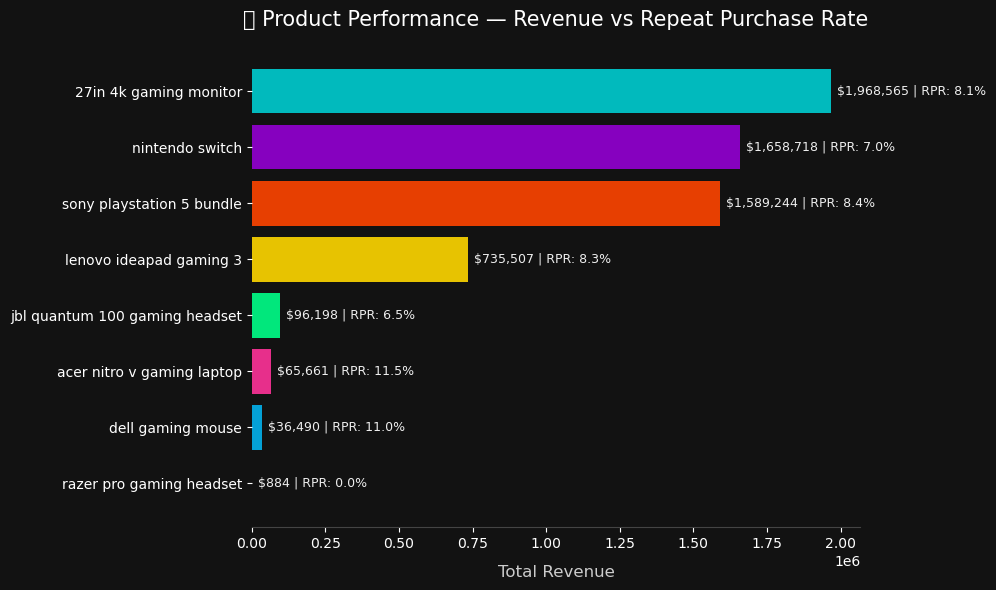

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 💾 Data ---
data = {
    'product_name_cleaned': [
        '27in 4k gaming monitor', 'nintendo switch', 'sony playstation 5 bundle',
        'lenovo ideapad gaming 3', 'jbl quantum 100 gaming headset',
        'acer nitro v gaming laptop', 'dell gaming mouse', 'razer pro gaming headset'
    ],
    'total_revenue': [1968565.34, 1658717.65, 1589243.85, 735506.56, 96197.67, 65661.18, 36490.01, 884.23],
    'rpr_%': [8.12, 6.99, 8.44, 8.27, 6.51, 11.54, 10.97, 0.0]
}

df = pd.DataFrame(data).sort_values('total_revenue', ascending=True)

# --- 🎨 Gaming-Inspired Palette (8 colors) ---
colors = [
    "#7B1FA2",  # Purple
    "#03b2ed",  # Neon Blue
    "#FF3399",  # Pink
    "#00FF88",  # Electric Green
    "#FFD700",  # Cyber Gold
    "#FF4500",  # Orange Flame
    "#9400D3",  # Deep Violet
    "#00CED1"   # Aqua Glow
]

# Assign colors to products dynamically
bar_colors = colors[:len(df)]

# --- 💰 Horizontal Product Performance Chart ---
fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.barh(
    df['product_name_cleaned'],
    df['total_revenue'],
    color=bar_colors,
    alpha=0.9
)

ax1.set_xlabel("Total Revenue", fontsize=12, labelpad=10, color="#CCCCCC")
ax1.set_ylabel("")  # No y-label needed
ax1.set_title("🎮 Product Performance — Revenue vs Repeat Purchase Rate", fontsize=15, pad=15, color="#FFFFFF")

# Style tweaks
ax1.tick_params(axis='y', labelsize=10, colors="#FFFFFF")
ax1.tick_params(axis='x', colors="#FFFFFF")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_color("#444444")
ax1.set_facecolor("#121212")
fig.patch.set_facecolor("#121212")

# Add text labels (product names & revenue)
for i, (rev, rpr) in enumerate(zip(df['total_revenue'], df['rpr_%'])):
    ax1.text(
        rev + max(df['total_revenue']) * 0.01,
        i,
        f"${rev:,.0f} | RPR: {rpr:.1f}%",
        va='center',
        fontsize=9,
        color="#EEEEEE"
    )

plt.grid(False)
plt.tight_layout()
plt.show()


C:\Users\shaif\AppData\Local\Temp\ipykernel_17152\2855588529.py:74: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


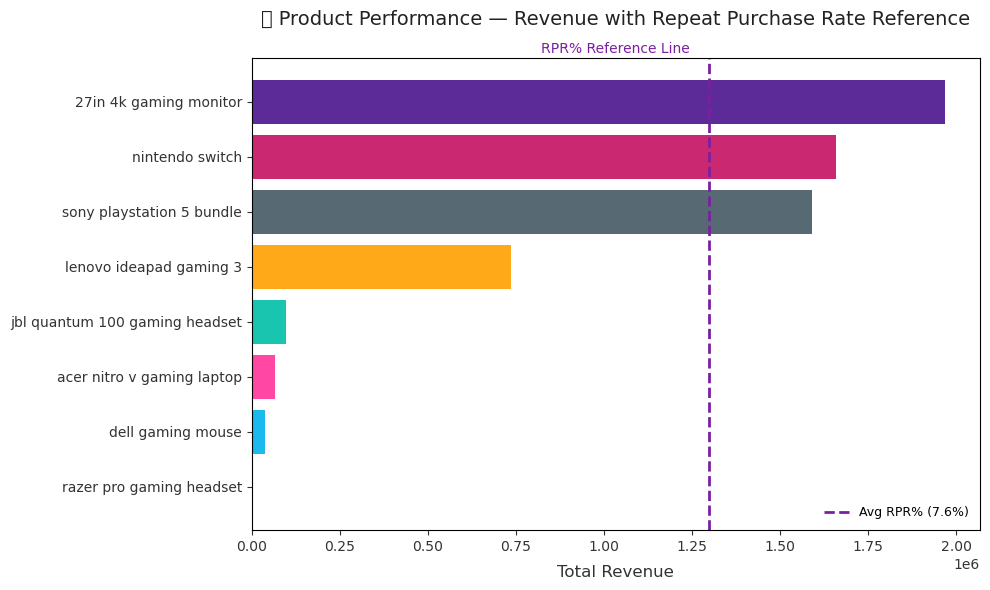

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 💾 Data ---
data = {
    'product_name_cleaned': [
        '27in 4k gaming monitor', 'nintendo switch', 'sony playstation 5 bundle',
        'lenovo ideapad gaming 3', 'jbl quantum 100 gaming headset',
        'acer nitro v gaming laptop', 'dell gaming mouse', 'razer pro gaming headset'
    ],
    'total_revenue': [1968565.34, 1658717.65, 1589243.85, 735506.56, 96197.67, 65661.18, 36490.01, 884.23],
    'rpr_%': [8.12, 6.99, 8.44, 8.27, 6.51, 11.54, 10.97, 0.0]
}
df = pd.DataFrame(data).sort_values('total_revenue', ascending=True)

# --- 🎨 Colour Palette (Original + Complementary, Gaming-Friendly) ---
colors = [
    "#7B1FA2",  # Purple
    "#03b2ed",  # Cyan Blue
    "#FF3399",  # Hot Pink
    "#00BFA6",  # Teal
    "#FFA000",  # Amber
    "#455A64",  # Slate Gray
    "#C51162",  # Magenta
    "#4A148C"   # Deep Violet
]
bar_colors = colors[:len(df)]

# --- 💰 Horizontal Product Performance Chart ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars (Total Revenue)
ax1.barh(
    df['product_name_cleaned'],
    df['total_revenue'],
    color=bar_colors,
    alpha=0.9
)

# Revenue Axis
ax1.set_xlabel("Total Revenue", fontsize=12, labelpad=8, color="#333333")
ax1.set_ylabel("")
ax1.set_title("🎮 Product Performance — Revenue with Repeat Purchase Rate Reference", 
              fontsize=14, pad=12, color="#222222")

# --- 🟣 Add RPR% Reference Line ---
avg_rpr = df['rpr_%'].mean()
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.axvline(
    x=(df['total_revenue'].max() * avg_rpr / df['rpr_%'].max()),
    color="#7B1FA2",
    linestyle="--",
    linewidth=2,
    label=f"Avg RPR% ({avg_rpr:.1f}%)"
)
ax2.set_xticks([])
ax2.set_xlabel("RPR% Reference Line", fontsize=10, color="#7B1FA2")

# --- 🎨 Style ---
ax1.tick_params(axis='y', labelsize=10, colors="#333333")
ax1.tick_params(axis='x', colors="#333333")
for spine in ax1.spines.values():
    spine.set_visible(False)

fig.patch.set_facecolor("white")
ax1.set_facecolor("white")

# Legend
ax2.legend(loc="lower right", frameon=False, fontsize=9)

plt.grid(False)
plt.tight_layout()
plt.show()


C:\Users\shaif\AppData\Local\Temp\ipykernel_17152\3013209801.py:74: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\shaif\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127918 (\N{VIDEO GAME}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


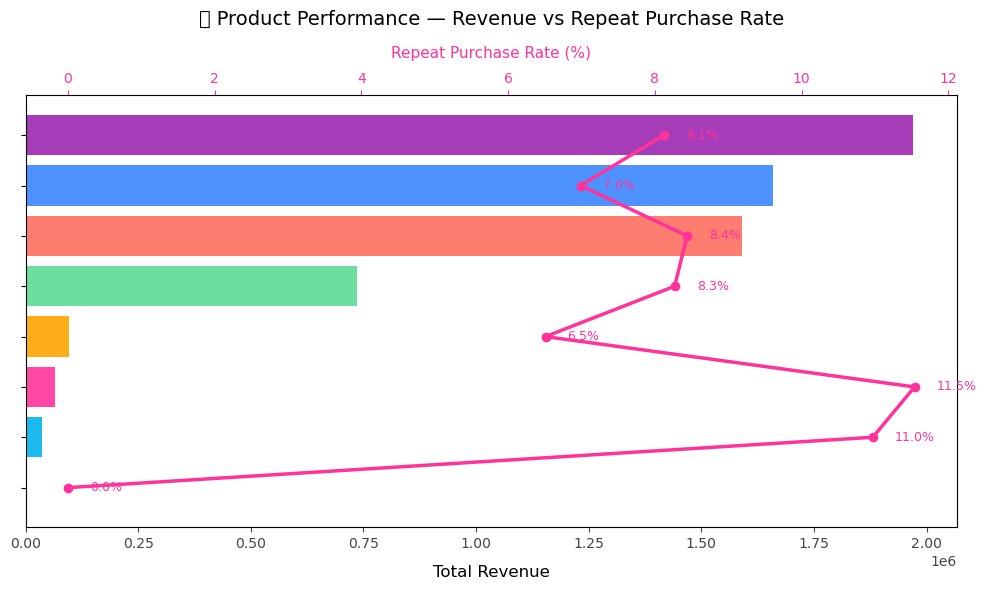

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 💾 Data ---
data = {
    'product_name_cleaned': [
        '27in 4k gaming monitor', 'nintendo switch', 'sony playstation 5 bundle',
        'lenovo ideapad gaming 3', 'jbl quantum 100 gaming headset',
        'acer nitro v gaming laptop', 'dell gaming mouse', 'razer pro gaming headset'
    ],
    'total_revenue': [1968565.34, 1658717.65, 1589243.85, 735506.56, 96197.67, 65661.18, 36490.01, 884.23],
    'rpr_%': [8.12, 6.99, 8.44, 8.27, 6.51, 11.54, 10.97, 0.0]
}

df = pd.DataFrame(data).sort_values('total_revenue', ascending=True)

# --- 🎨 Colour Palette (3 core + 5 complements) ---
colors = [
    "#7B1FA2",  # Purple
    "#03b2ed",  # Blue
    "#FF3399",  # Pink
    "#FFA500",  # Orange
    "#5CDB95",  # Mint Green
    "#FF6F61",  # Coral
    "#3A86FF",  # Electric Blue
    "#9C27B0"   # Deep Violet
]
bar_colors = colors[:len(df)]

# --- 💰 Product Performance Chart ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars for Revenue
bars = ax1.barh(
    df['product_name_cleaned'],
    df['total_revenue'],
    color=bar_colors,
    alpha=0.9
)

# Labels & axes styling
ax1.set_xlabel("Total Revenue", fontsize=12, labelpad=10)
ax1.set_ylabel("")
ax1.set_title("🎮 Product Performance — Revenue vs Repeat Purchase Rate", fontsize=14, pad=15)

ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', colors="#444444")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_color("#DDDDDD")
ax1.set_facecolor("#FFFFFF")
fig.patch.set_facecolor("#FFFFFF")

# --- 📈 Add RPR% Reference Lines ---
ax2 = ax1.twiny()  # Create second x-axis for RPR%
ax2.plot(df['rpr_%'], np.arange(len(df)), color="#FF3399", marker='o', linewidth=2.5, label="RPR%")

# Sync y-axis
ax2.set_yticks(np.arange(len(df)))
ax2.set_yticklabels([])
ax2.set_xlabel("Repeat Purchase Rate (%)", fontsize=11, color="#FF3399", labelpad=10)
ax2.tick_params(axis='x', colors="#FF3399")

# Hide grid
ax1.grid(False)
ax2.grid(False)

# --- Annotate RPR values at the line points ---
for i, rpr in enumerate(df['rpr_%']):
    ax2.text(rpr + 0.3, i, f"{rpr:.1f}%", va='center', color="#FF3399", fontsize=9)

plt.tight_layout()
plt.show()


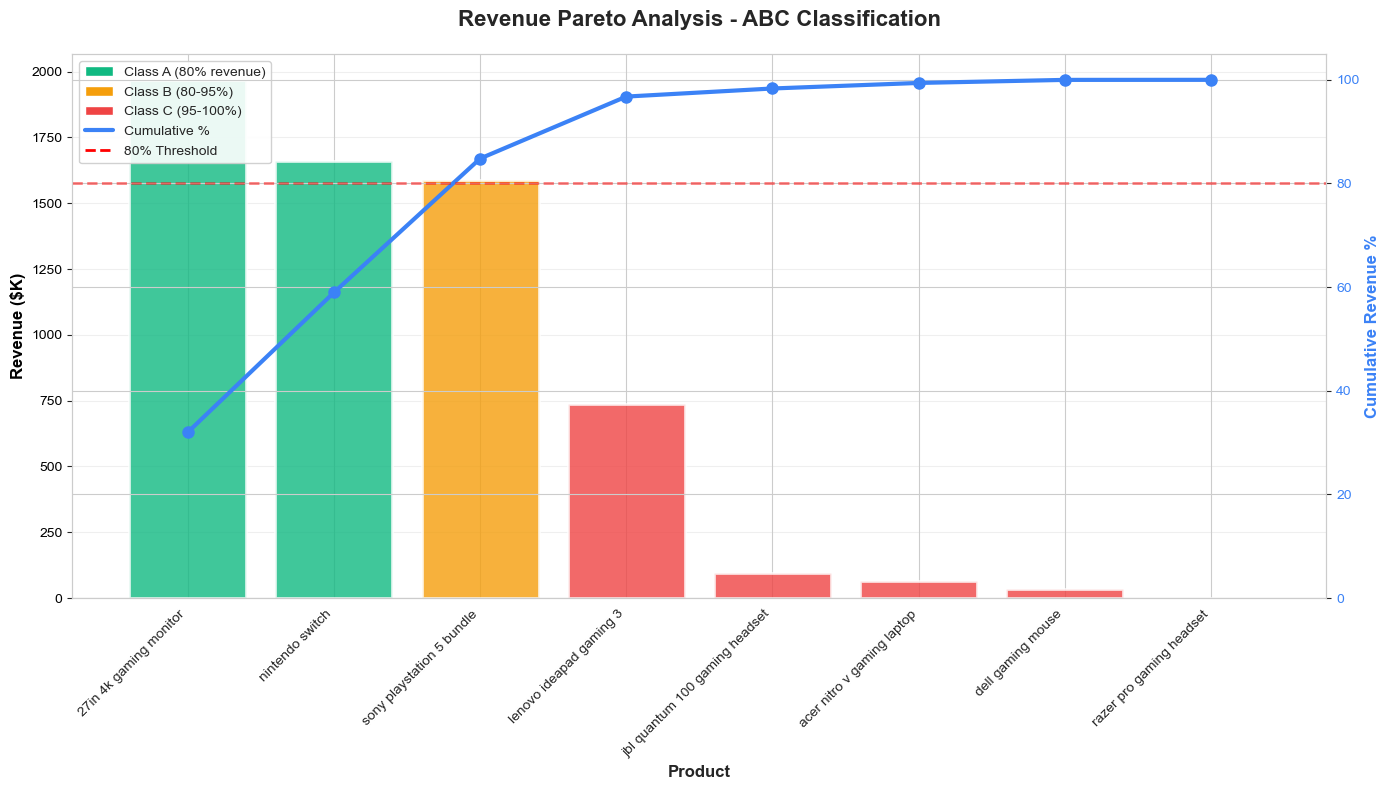

✅ Chart 1 saved: pareto_analysis.png


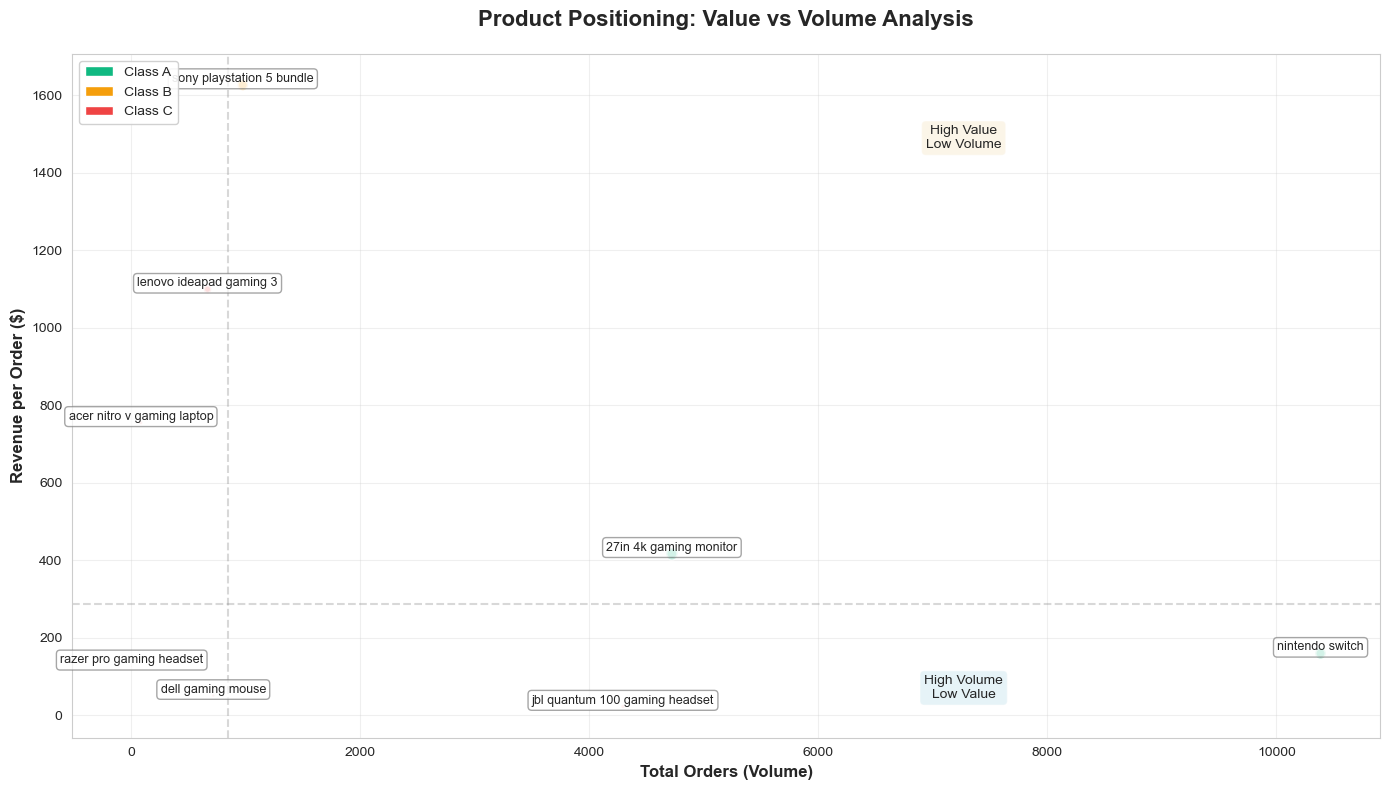

✅ Chart 2 saved: value_vs_volume.png


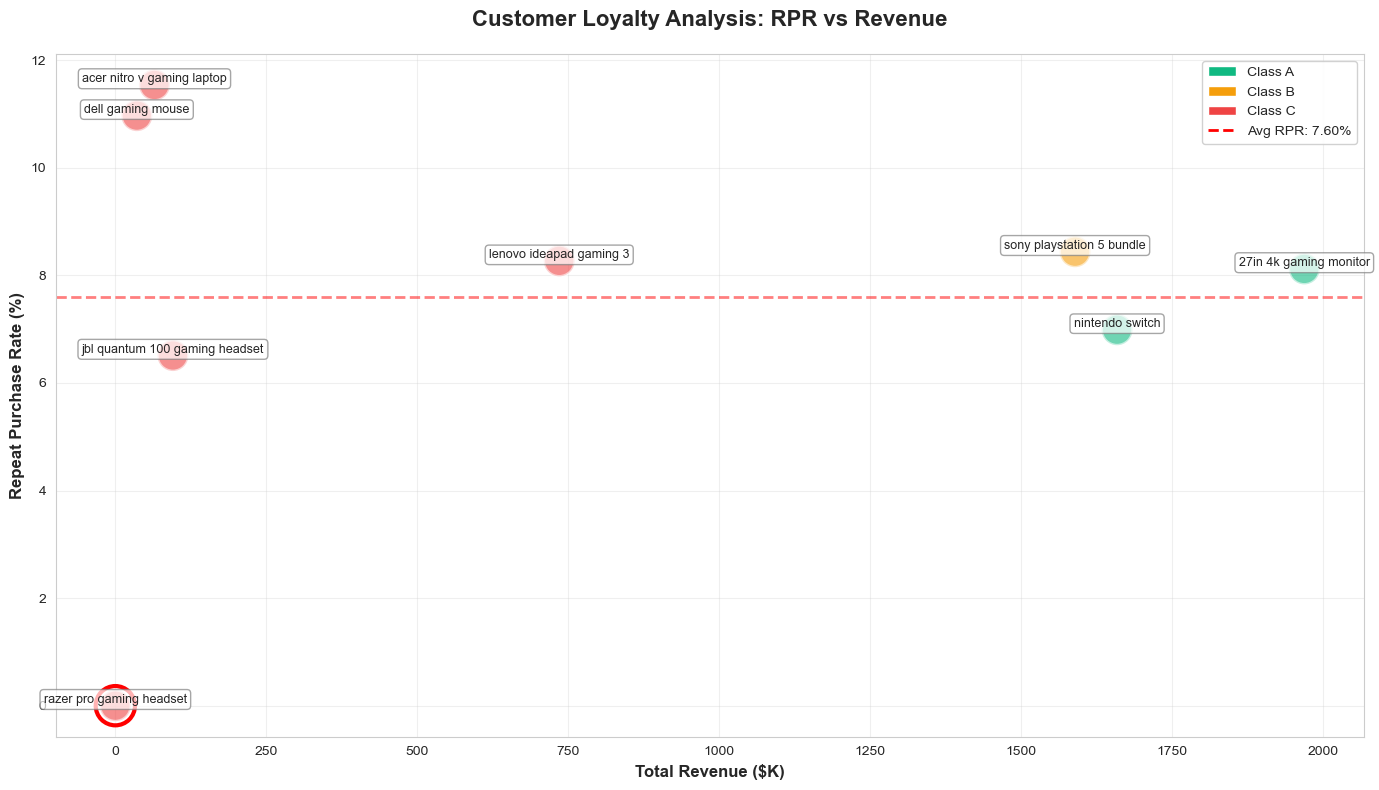

✅ Chart 3 saved: loyalty_analysis.png


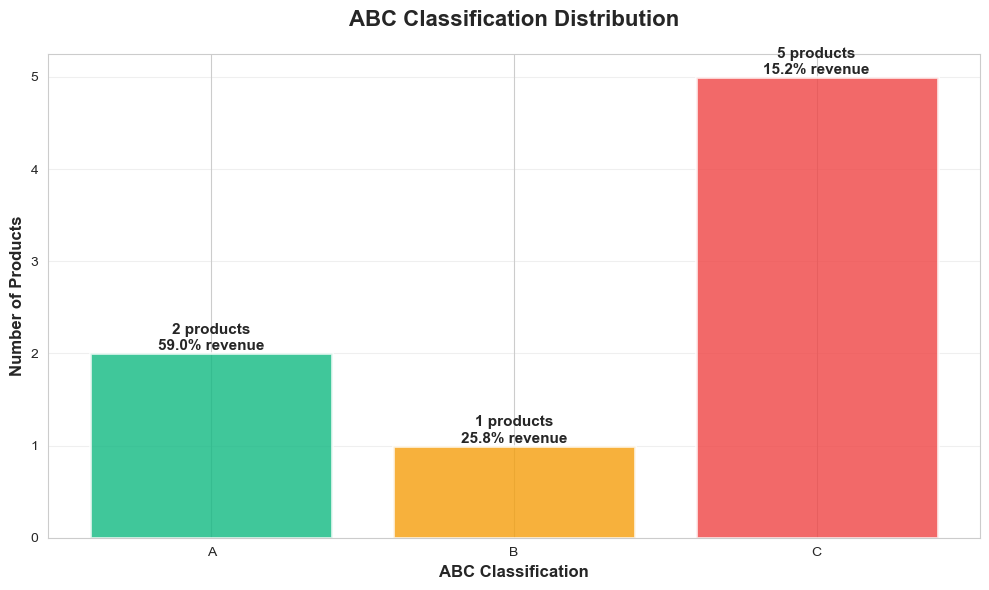

✅ Chart 4 saved: abc_distribution.png


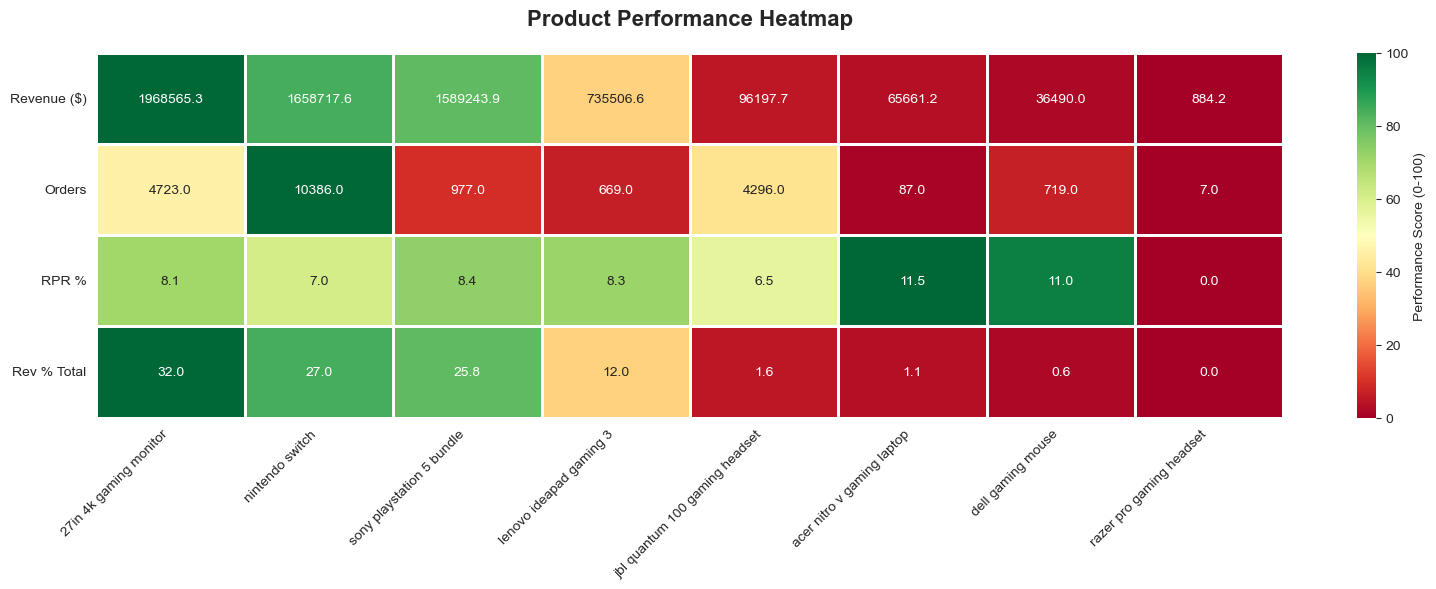

✅ Chart 5 saved: performance_heatmap.png

📊 PRODUCT PERFORMANCE SUMMARY STATISTICS

Total Products: 8
Total Revenue: $6,151,266.49
Total Orders: 21,864
Average RPR: 7.60%

ABC Distribution:
  Class A: 2 products (80% revenue)
  Class B: 1 products (80-95% revenue)
  Class C: 5 products (95-100% revenue)

🚨 Critical Issues:
  • razer pro gaming headset: 0% RPR

✅ Top Performers:
  • Highest Revenue: 27in 4k gaming monitor
  • Highest RPR: acer nitro v gaming laptop (11.54%)


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for professional-looking charts
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Load your data (assuming product_performance DataFrame exists)
# If you have the CSV, load it:
# product_performance = pd.read_csv('product_performance.csv')

# For this example, I'll recreate the data
data = {
    'product_name_cleaned': ['27in 4k gaming monitor', 'nintendo switch', 'sony playstation 5 bundle', 
                              'lenovo ideapad gaming 3', 'jbl quantum 100 gaming headset', 
                              'acer nitro v gaming laptop', 'dell gaming mouse', 'razer pro gaming headset'],
    'total_revenue': [1968565.34, 1658717.65, 1589243.85, 735506.56, 96197.67, 65661.18, 36490.01, 884.23],
    'total_orders': [4723, 10386, 977, 669, 4296, 87, 719, 7],
    'avg_price': [417.51, 159.71, 1626.66, 1099.41, 22.50, 754.73, 51.11, 126.32],
    'total_customers': [4358, 9686, 900, 617, 4025, 78, 647, 7],
    'repeat_buyers': [354, 677, 76, 51, 262, 9, 71, 0],
    'rpr_%': [8.12, 6.99, 8.44, 8.27, 6.51, 11.54, 10.97, 0.0],
    'revenue_%_of_total': [32.0, 26.97, 25.84, 11.96, 1.56, 1.07, 0.59, 0.01],
    'cumulative_revenue_%': [32.0, 58.97, 84.81, 96.77, 98.33, 99.4, 99.99, 100.0],
    'revenue_per_order': [416.8, 159.71, 1626.66, 1099.41, 22.39, 754.73, 50.75, 126.32],
    'abc_class': ['A', 'A', 'B', 'C', 'C', 'C', 'C', 'C']
}

product_performance = pd.DataFrame(data)

# Define ABC colors
abc_colors = {'A': '#10b981', 'B': '#f59e0b', 'C': '#ef4444'}
colors = [abc_colors[abc] for abc in product_performance['abc_class']]

# ============================================================
# CHART 1: PARETO ANALYSIS (Revenue + Cumulative %)
# ============================================================
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar chart for revenue
x_pos = np.arange(len(product_performance))
bars = ax1.bar(x_pos, product_performance['total_revenue']/1000, 
               color=colors, alpha=0.8, edgecolor='white', linewidth=2)

ax1.set_xlabel('Product', fontsize=12, fontweight='bold')
ax1.set_ylabel('Revenue ($K)', fontsize=12, fontweight='bold', color='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(product_performance['product_name_cleaned'], 
                     rotation=45, ha='right', fontsize=10)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(axis='y', alpha=0.3)

# Line chart for cumulative %
ax2 = ax1.twinx()
line = ax2.plot(x_pos, product_performance['cumulative_revenue_%'], 
                color='#3b82f6', marker='o', linewidth=3, markersize=8, label='Cumulative %')
ax2.set_ylabel('Cumulative Revenue %', fontsize=12, fontweight='bold', color='#3b82f6')
ax2.tick_params(axis='y', labelcolor='#3b82f6')
ax2.set_ylim(0, 105)

# Add 80% reference line
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, alpha=0.5, label='80% Threshold')

# Title and legend
plt.title('Revenue Pareto Analysis - ABC Classification', 
          fontsize=16, fontweight='bold', pad=20)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#10b981', label='Class A (80% revenue)'),
    Patch(facecolor='#f59e0b', label='Class B (80-95%)'),
    Patch(facecolor='#ef4444', label='Class C (95-100%)'),
    plt.Line2D([0], [0], color='#3b82f6', linewidth=3, label='Cumulative %'),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='80% Threshold')
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('pareto_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart 1 saved: pareto_analysis.png")

# ============================================================
# CHART 2: BUBBLE CHART (Value vs Volume)
# ============================================================
fig, ax = plt.subplots(figsize=(14, 8))

# Create bubble sizes based on revenue (scale for visibility)
sizes = (product_performance['total_revenue'] / 10000) ** 0.8

scatter = ax.scatter(product_performance['total_orders'], 
                     product_performance['revenue_per_order'],
                     s=sizes, c=colors, alpha=0.6, edgecolors='white', linewidth=2)

# Add product labels
for idx, row in product_performance.iterrows():
    ax.annotate(row['product_name_cleaned'], 
                (row['total_orders'], row['revenue_per_order']),
                fontsize=9, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'))

ax.set_xlabel('Total Orders (Volume)', fontsize=12, fontweight='bold')
ax.set_ylabel('Revenue per Order ($)', fontsize=12, fontweight='bold')
ax.set_title('Product Positioning: Value vs Volume Analysis', 
             fontsize=16, fontweight='bold', pad=20)

# Add quadrant lines (median split)
median_orders = product_performance['total_orders'].median()
median_rev_per_order = product_performance['revenue_per_order'].median()
ax.axvline(median_orders, color='gray', linestyle='--', alpha=0.3)
ax.axhline(median_rev_per_order, color='gray', linestyle='--', alpha=0.3)

# Add quadrant labels
ax.text(product_performance['total_orders'].max() * 0.7, 
        product_performance['revenue_per_order'].max() * 0.9,
        'High Value\nLow Volume', fontsize=10, ha='center', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
ax.text(product_performance['total_orders'].max() * 0.7, 
        product_performance['revenue_per_order'].min() * 2,
        'High Volume\nLow Value', fontsize=10, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

ax.grid(True, alpha=0.3)

# Legend
legend_elements = [
    Patch(facecolor='#10b981', label='Class A'),
    Patch(facecolor='#f59e0b', label='Class B'),
    Patch(facecolor='#ef4444', label='Class C')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('value_vs_volume.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart 2 saved: value_vs_volume.png")

# ============================================================
# CHART 3: LOYALTY ANALYSIS (RPR vs Revenue)
# ============================================================
fig, ax = plt.subplots(figsize=(14, 8))

scatter = ax.scatter(product_performance['total_revenue']/1000, 
                     product_performance['rpr_%'],
                     s=500, c=colors, alpha=0.6, edgecolors='white', linewidth=2)

# Add product labels
for idx, row in product_performance.iterrows():
    ax.annotate(row['product_name_cleaned'], 
                (row['total_revenue']/1000, row['rpr_%']),
                fontsize=9, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'))

ax.set_xlabel('Total Revenue ($K)', fontsize=12, fontweight='bold')
ax.set_ylabel('Repeat Purchase Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Customer Loyalty Analysis: RPR vs Revenue', 
             fontsize=16, fontweight='bold', pad=20)

# Add average lines
avg_rpr = product_performance['rpr_%'].mean()
ax.axhline(avg_rpr, color='red', linestyle='--', linewidth=2, alpha=0.5, 
           label=f'Avg RPR: {avg_rpr:.2f}%')

# Highlight critical issue (0% RPR)
critical = product_performance[product_performance['rpr_%'] == 0]
if not critical.empty:
    ax.scatter(critical['total_revenue']/1000, critical['rpr_%'], 
               s=800, facecolors='none', edgecolors='red', linewidths=3, 
               label='Critical: 0% RPR')

ax.grid(True, alpha=0.3)

# Legend
legend_elements = [
    Patch(facecolor='#10b981', label='Class A'),
    Patch(facecolor='#f59e0b', label='Class B'),
    Patch(facecolor='#ef4444', label='Class C'),
    plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label=f'Avg RPR: {avg_rpr:.2f}%')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('loyalty_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart 3 saved: loyalty_analysis.png")

# ============================================================
# CHART 4: ABC SUMMARY BAR CHART
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

abc_summary = product_performance.groupby('abc_class').agg({
    'product_name_cleaned': 'count',
    'total_revenue': 'sum',
    'revenue_%_of_total': 'sum'
}).reset_index()
abc_summary.columns = ['ABC Class', 'Product Count', 'Total Revenue', 'Revenue %']

bars = ax.bar(abc_summary['ABC Class'], abc_summary['Product Count'], 
              color=[abc_colors[c] for c in abc_summary['ABC Class']], 
              alpha=0.8, edgecolor='white', linewidth=2)

# Add value labels on bars
for bar, count, rev_pct in zip(bars, abc_summary['Product Count'], abc_summary['Revenue %']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)} products\n{rev_pct:.1f}% revenue',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('ABC Classification', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
ax.set_title('ABC Classification Distribution', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('abc_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart 4 saved: abc_distribution.png")

# ============================================================
# CHART 5: HEATMAP TABLE (for detailed report)
# ============================================================
fig, ax = plt.subplots(figsize=(16, 6))

# Select key metrics for heatmap
heatmap_data = product_performance[['product_name_cleaned', 'total_revenue', 'total_orders', 
                                     'rpr_%', 'revenue_%_of_total', 'abc_class']].copy()

# Normalize numeric columns for heatmap (0-100 scale)
numeric_cols = ['total_revenue', 'total_orders', 'rpr_%', 'revenue_%_of_total']
heatmap_normalized = heatmap_data[numeric_cols].copy()
for col in numeric_cols:
    heatmap_normalized[col] = (heatmap_normalized[col] / heatmap_normalized[col].max() * 100)

# Create heatmap
sns.heatmap(heatmap_normalized.T, annot=heatmap_data[numeric_cols].T, 
            fmt='.1f', cmap='RdYlGn', cbar_kws={'label': 'Performance Score (0-100)'},
            xticklabels=heatmap_data['product_name_cleaned'], 
            yticklabels=['Revenue ($)', 'Orders', 'RPR %', 'Rev % Total'],
            linewidths=1, linecolor='white')

ax.set_title('Product Performance Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart 5 saved: performance_heatmap.png")

# ============================================================
# SUMMARY STATISTICS TABLE (for report)
# ============================================================
print("\n" + "="*80)
print("📊 PRODUCT PERFORMANCE SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal Products: {len(product_performance)}")
print(f"Total Revenue: ${product_performance['total_revenue'].sum():,.2f}")
print(f"Total Orders: {product_performance['total_orders'].sum():,}")
print(f"Average RPR: {product_performance['rpr_%'].mean():.2f}%")
print(f"\nABC Distribution:")
print(f"  Class A: {len(product_performance[product_performance['abc_class']=='A'])} products (80% revenue)")
print(f"  Class B: {len(product_performance[product_performance['abc_class']=='B'])} products (80-95% revenue)")
print(f"  Class C: {len(product_performance[product_performance['abc_class']=='C'])} products (95-100% revenue)")
print(f"\n🚨 Critical Issues:")
print(f"  • {product_performance[product_performance['rpr_%']==0]['product_name_cleaned'].values[0]}: 0% RPR")
print(f"\n✅ Top Performers:")
print(f"  • Highest Revenue: {product_performance.iloc[0]['product_name_cleaned']}")
print(f"  • Highest RPR: {product_performance.nlargest(1, 'rpr_%')['product_name_cleaned'].values[0]} ({product_performance['rpr_%'].max()}%)")
print("="*80)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set color palette
COLORS = {
    "purple": "#7B1FA2",
    "blue": "#03b2ed",
    "pink": "#FF3399",
    "dark": "#000000",
    "light_gray": "#f5f5f5"
}

plt.style.use("default")
sns.set_theme(style="whitegrid")

# -------------------------------------------
# 1️⃣ PRODUCT PERFORMANCE BASE TABLE
# -------------------------------------------

product_performance = (
    df.groupby(['product_name_cleaned'])
    .agg(
        total_revenue=('revenue', 'sum'),
        total_orders=('order_id', 'count'),
        avg_price=('revenue', 'mean'),
        total_customers=('user_id', 'nunique')
    )
    .reset_index()
)

# -------------------------------------------
# 2️⃣ REPEAT PURCHASE RATE (RPR)
# -------------------------------------------
repeat_buyers = (
    df.groupby(['product_name_cleaned', 'user_id'])
    .size()
    .reset_index(name='purchase_count')
)
repeat_buyers = repeat_buyers[repeat_buyers['purchase_count'] > 1]

repeat_buyers_count = (
    repeat_buyers.groupby('product_name_cleaned')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'repeat_buyers'})
)

product_performance = product_performance.merge(
    repeat_buyers_count, on='product_name_cleaned', how='left'
)
product_performance['repeat_buyers'] = product_performance['repeat_buyers'].fillna(0)

product_performance['rpr_%'] = (
    product_performance['repeat_buyers'] / product_performance['total_customers'] * 100
).round(2)

# -------------------------------------------
# 3️⃣ ADD SHARE OF REVENUE, CUMULATIVE %, REVENUE/ORDER
# -------------------------------------------
product_performance = product_performance.sort_values(by='total_revenue', ascending=False)

total_revenue_sum = product_performance['total_revenue'].sum()
product_performance['revenue_%_of_total'] = (
    product_performance['total_revenue'] / total_revenue_sum * 100
).round(2)

product_performance['cumulative_revenue_%'] = (
    product_performance['revenue_%_of_total'].cumsum()
).round(2)

product_performance['revenue_per_order'] = (
    product_performance['total_revenue'] / product_performance['total_orders']
).round(2)

# -------------------------------------------
# 4️⃣ ABC CLASSIFICATION (PARETO)
# -------------------------------------------
def classify_abc(cum_pct):
    if cum_pct <= 80:
        return 'A'
    elif cum_pct <= 95:
        return 'B'
    else:
        return 'C'

product_performance['abc_class'] = product_performance['cumulative_revenue_%'].apply(classify_abc)

# -------------------------------------------
# 5️⃣ PARETO CHART — REVENUE DISTRIBUTION
# -------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 5))
bars = ax1.bar(
    product_performance['product_name_cleaned'],
    product_performance['total_revenue'],
    color=COLORS['purple'],
    alpha=0.85,
    label='Revenue'
)

ax2 = ax1.twinx()
ax2.plot(
    product_performance['product_name_cleaned'],
    product_performance['cumulative_revenue_%'],
    color=COLORS['blue'],
    marker='o',
    linewidth=2,
    label='Cumulative %'
)

ax1.set_ylabel("Revenue", color=COLORS['purple'])
ax2.set_ylabel("Cumulative % of Revenue", color=COLORS['blue'])
ax1.set_title("Pareto Chart — Product Revenue Contribution", fontsize=13, fontweight='bold')

ax1.grid(False)
ax2.grid(False)
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

# -------------------------------------------
# 6️⃣ VALUE vs VOLUME — BUBBLE CHART
# -------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(
    product_performance['total_orders'],
    product_performance['avg_price'],
    s=product_performance['total_revenue'] / 2000,
    c=COLORS['pink'],
    alpha=0.7,
    edgecolors=COLORS['dark']
)
plt.title("Value vs Volume (Bubble = Revenue)", fontsize=13, fontweight='bold')
plt.xlabel("Total Orders")
plt.ylabel("Average Price")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------------------
# 7️⃣ RPR vs REVENUE — CUSTOMER LOYALTY
# -------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='rpr_%',
    y='total_revenue',
    data=product_performance,
    color=COLORS['blue'],
    s=120,
    edgecolor=COLORS['purple']
)
plt.title("Repeat Purchase Rate vs Revenue", fontsize=13, fontweight='bold')
plt.xlabel("RPR %")
plt.ylabel("Revenue")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------------------
# 8️⃣ ABC SUMMARY BAR CHART
# -------------------------------------------
abc_summary = (
    product_performance.groupby('abc_class')['total_revenue']
    .sum()
    .reset_index()
    .sort_values(by='abc_class')
)
abc_summary['revenue_%'] = (
    abc_summary['total_revenue'] / abc_summary['total_revenue'].sum() * 100
).round(2)

sns.barplot(
    data=abc_summary,
    x='abc_class',
    y='revenue_%',
    palette=[COLORS['purple'], COLORS['blue'], COLORS['pink']]
)
plt.title("ABC Class Revenue Distribution", fontsize=13, fontweight='bold')
plt.xlabel("Class")
plt.ylabel("% of Total Revenue")
plt.grid(False)
plt.tight_layout()
plt.show()

# -------------------------------------------
# 9️⃣ HEATMAP — MULTI-METRIC COMPARISON
# -------------------------------------------
heatmap_data = product_performance.set_index('product_name_cleaned')[
    ['total_revenue', 'total_orders', 'rpr_%', 'revenue_%_of_total']
]

plt.figure(figsize=(10, 5))
sns.heatmap(
    heatmap_data,
    cmap=[COLORS['purple'], COLORS['blue'], COLORS['pink']],
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
plt.title("Product Performance Heatmap", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# -------------------------------------------
# 🔟 SAVE FINAL DATA
# -------------------------------------------
product_performance.to_excel("product_performance_report.xlsx", index=False)
print("✅ Product performance report generated and saved successfully.")


KeyError: "Column(s) ['order_id', 'revenue', 'user_id'] do not exist"